<a href="https://www.kaggle.com/luisprezsala/batman?scriptVersionId=90019256" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
######## Loading Files ########
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

DATASET_PATH = '../input/sanfranciscopolicedepartmentincidentreports/'
INCIDENTS_FILE = 'Police_Department_Incident_Reports__2018_to_Present.csv'
SCHOOLS_FILE  = 'Schools.csv'
COLLEGES_FILE = 'Schools_College.csv' 

incidents_df = pd.read_csv(DATASET_PATH + INCIDENTS_FILE)
schools_df   = pd.read_csv(DATASET_PATH + SCHOOLS_FILE)
colleges_df  = pd.read_csv(DATASET_PATH + COLLEGES_FILE)

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,...,Longitude,Point,Neighborhoods,ESNCAG - Boundary File,Central Market/Tenderloin Boundary Polygon - Updated,Civic Center Harm Reduction Project Boundary,HSOC Zones as of 2018-06-05,Invest In Neighborhoods (IIN) Areas,Current Supervisor Districts,Current Police Districts
364024,2020-01-01,2020/01/01,00:00,2020,Wednesday,2020/02/19 07:00:00 AM,90443972000,904439,190629803,192372426.0,...,-122.397479,POINT (-122.39747873558031 37.718834357405456),88.0,NaN,NaN,NaN,NaN,NaN,9.0,2.0
414730,2020-01-01,2020/01/01,00:00,2020,Wednesday,2020/04/22 02:06:00 PM,92130664070,921306,200254144,201131818.0,...,-122.412547,POINT (-122.41254705065515 37.746824998777896),83.0,NaN,NaN,NaN,3.0,NaN,2.0,9.0
87443,2020-01-01,2020/01/01,00:00,2020,Wednesday,2021/12/30 02:00:00 PM,110745964070,1107459,210863440,213642117.0,...,-122.391374,POINT (-122.39137353346597 37.77283099431839),34.0,NaN,NaN,NaN,NaN,NaN,10.0,1.0
517116,2020-01-01,2020/01/01,00:00,2020,Wednesday,2020/06/27 01:59:00 PM,93907606372,939076,206099271,NaN,...,-122.388738,POINT (-122.38873799945695 37.76304827811293),55.0,NaN,NaN,NaN,NaN,NaN,9.0,2.0
461080,2020-01-01,2020/01/01,00:00,2020,Wednesday,2020/03/03 02:10:00 PM,90907968030,909079,200160262,200632310.0,...,-122.392723,POINT (-122.39272283486896 37.78868666104212),32.0,1.0,NaN,NaN,NaN,NaN,10.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533463,2020-12-31,2020/12/31,00:00,2020,Thursday,2021/01/01 03:33:00 PM,99207706244,992077,210001349,210012022.0,...,-122.502031,POINT (-122.5020311786853 37.73551490812246),40.0,NaN,NaN,NaN,NaN,NaN,8.0,10.0
498840,2020-12-31,2020/12/31,00:00,2020,Thursday,2021/01/02 03:24:00 PM,99275406374,992754,216000177,NaN,...,-122.435563,POINT (-122.43556332140828 37.7724179289558),26.0,NaN,NaN,NaN,NaN,NaN,11.0,4.0
538116,2020-12-31,2020/12/31,00:00,2020,Thursday,2021/01/19 09:36:00 AM,99804306244,998043,216006959,NaN,...,-122.423413,POINT (-122.42341305643612 37.79573710834212),102.0,NaN,NaN,NaN,NaN,NaN,6.0,4.0
542339,2020-12-31,2020/12/31,00:00,2020,Thursday,2021/01/01 03:39:00 PM,99275205073,992752,210000880,NaN,...,-122.475924,POINT (-122.47592409365181 37.76174715066737),109.0,NaN,NaN,NaN,NaN,NaN,7.0,10.0


126995


,Incident Year,Row ID,Incident ID,Incident Number,CAD Number,Incident Code,CNN,Supervisor District,Latitude,Longitude,Neighborhoods,ESNCAG - Boundary File,Central Market/Tenderloin Boundary Polygon - Updated,Civic Center Harm Reduction Project Boundary,HSOC Zones as of 2018-06-05,Invest In Neighborhoods (IIN) Areas,Current Supervisor Districts,Current Police Districts
Incident Datetime,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,2021.0,1.038389e+11,1.038388e+06,2.127773e+08,2.124400e+08,30008.375000,2.542700e+07,5.391304,37.768992,-122.431060,64.380952,1.0,1.0,NaN,3.000000,NaN,6.608696,5.565217
2021-01-01 00:01:00,2021.0,1.043685e+11,1.043685e+06,2.130805e+08,2.122008e+08,27350.222222,2.354444e+07,7.444444,37.743873,-122.436480,55.500000,NaN,1.0,NaN,5.000000,NaN,5.000000,6.333333
2021-01-01 00:02:00,2021.0,9.954721e+10,9.954720e+05,2.160035e+08,NaN,6244.000000,2.794900e+07,4.000000,37.762285,-122.506059,39.000000,NaN,NaN,NaN,NaN,NaN,7.000000,10.000000
2021-01-01 00:05:00,2021.0,1.044947e+11,1.044946e+06,2.104082e+08,2.118025e+08,71000.000000,2.326200e+07,4.000000,37.744681,-122.481181,40.000000,NaN,NaN,NaN,NaN,NaN,7.000000,10.000000
2021-01-01 00:20:00,2021.0,9.919166e+10,9.919165e+05,2.100001e+08,2.100101e+08,12882.250000,2.783150e+07,4.500000,37.786598,-122.406985,64.000000,NaN,1.0,1.0,NaN,NaN,6.500000,5.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30 22:27:00,2021.0,1.108481e+11,1.108481e+06,2.162076e+08,NaN,6244.000000,2.670500e+07,2.000000,37.804146,-122.425110,17.000000,NaN,NaN,NaN,NaN,NaN,6.000000,6.000000
2021-12-30 22:30:00,2021.0,1.113394e+11,1.113394e+06,2.197702e+08,2.201274e+08,20322.500000,2.704200e+07,7.250000,37.768267,-122.409178,59.250000,NaN,NaN,1.0,2.333333,NaN,6.250000,2.750000
2021-12-30 22:56:00,2021.0,1.107569e+11,1.107569e+06,2.108642e+08,2.136431e+08,15161.000000,2.659500e+07,5.000000,37.783083,-122.434350,97.000000,NaN,NaN,NaN,NaN,NaN,11.000000,4.000000


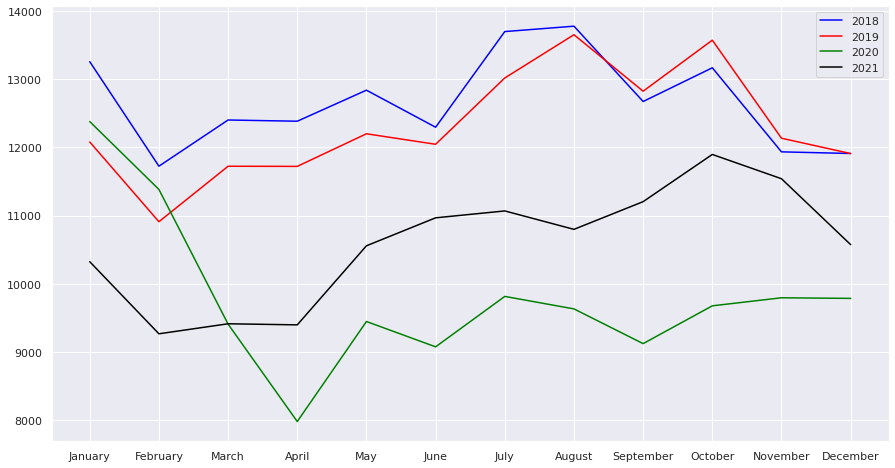

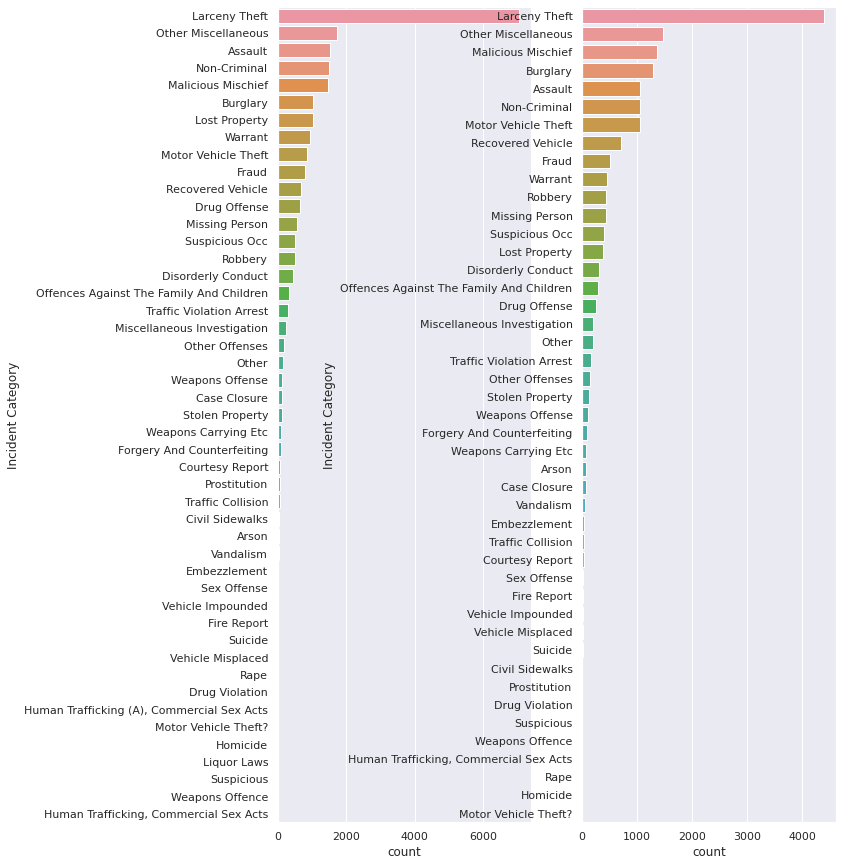

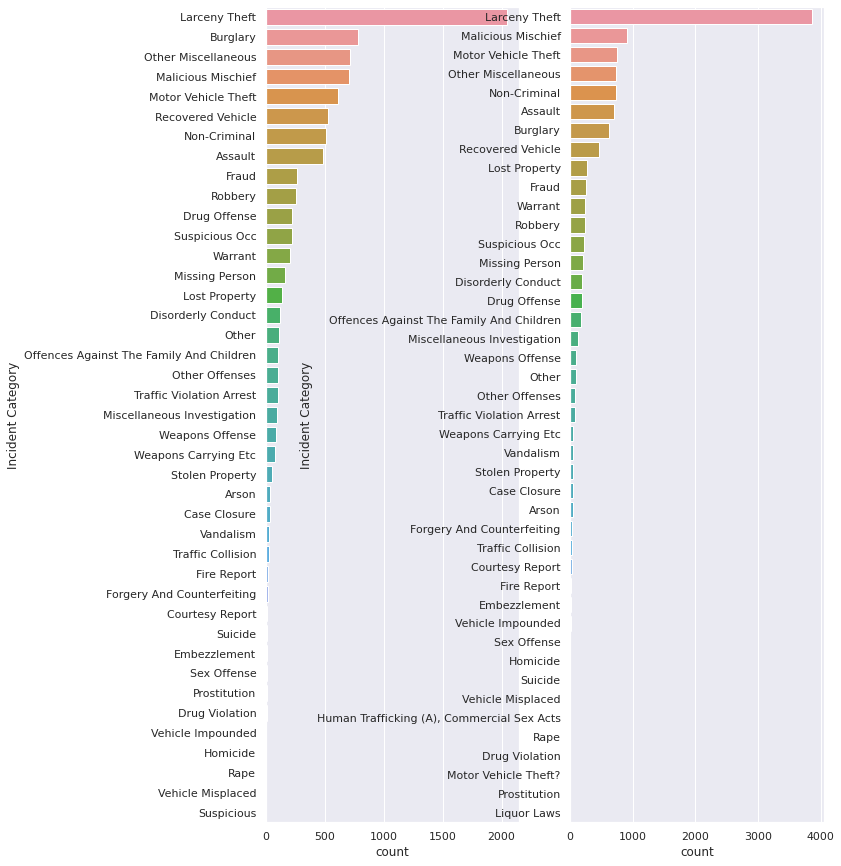

In [2]:
incidents_df['Incident Datetime'] = pd.to_datetime(incidents_df['Incident Datetime'])
incidents_df = incidents_df.sort_values('Incident Datetime')

incidents_2018 = incidents_df[incidents_df['Incident Datetime'].between('2018-01-01', '2018-12-31')]
incidents_2019 = incidents_df[incidents_df['Incident Datetime'].between('2019-01-01', '2019-12-31')]
incidents_2020 = incidents_df[incidents_df['Incident Datetime'].between('2020-01-01', '2020-12-31')]
incidents_2021 = incidents_df[incidents_df['Incident Datetime'].between('2021-01-01', '2021-12-31')]
incidents_2022 = incidents_df[incidents_df['Incident Datetime'].between('2022-01-01', '2022-12-31')]

# incidents_2022.groupby(by=[incidents_2022.index.month,incidents_2022.index.year])
monthly_2018 = incidents_2018.groupby(incidents_2018['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2019 = incidents_2019.groupby(incidents_2019['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2020 = incidents_2020.groupby(incidents_2020['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2021 = incidents_2021.groupby(incidents_2021['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()
monthly_2022 = incidents_2022.groupby(incidents_2022['Incident Datetime'].dt.strftime('%B'))['Incident Datetime'].count()

display(incidents_2020)

months_sorted = sorted(monthly_2021.keys(), key=lambda day: datetime.strptime(day, "%B"))

test_2018 = [] 
test_2019 = []
test_2020 = []
test_2021 = []
test_2022 = []

for month in months_sorted:
    test_2018.append(monthly_2018[month])
    test_2019.append(monthly_2019[month])
    test_2020.append(monthly_2020[month])
    test_2021.append(monthly_2021[month])
#     if monthly_2022[month]: test_2022.append(monthly_2022[month])

sns.set_theme(style="darkgrid")

sns.set(rc={'figure.figsize':(15,8)})

sns.lineplot(x=months_sorted, y=test_2018, color='blue', legend='brief', label=str('2018'))
sns.lineplot(x=months_sorted, y=test_2019, color='red', legend='brief', label=str('2019'))
sns.lineplot(x=months_sorted, y=test_2020, color='green',  legend='brief', label=str('2020'))
sns.lineplot(x=months_sorted, y=test_2021, color='black',  legend='brief', label=str('2021'))


############ COVID ############
covid_epoch = incidents_2020[incidents_2020['Incident Datetime'].between('2020-03-01', '2020-05-01')]
not_covid_epoch = incidents_2019[incidents_2019['Incident Datetime'].between('2019-03-01', '2019-05-01')]

covid_order = pd.Categorical(covid_epoch['Incident Category'].value_counts().index)
not_covid_order = pd.Categorical(not_covid_epoch['Incident Category'].value_counts().index)

sns.set(rc={'figure.figsize':(10,15)})
fig, ax =plt.subplots(1,2)
sns.countplot(data=not_covid_epoch, y="Incident Category", order = not_covid_order, ax=ax[0])
sns.countplot(data=covid_epoch, y="Incident Category", order = covid_order, ax=ax[1])

############ SUMMER ############
october_epoch = incidents_2021[incidents_2021['Incident Datetime'].between('2021-02-01', '2021-02-28')]
february_epoch = incidents_2021[incidents_2021['Incident Datetime'].between('2021-10-01', '2021-10-31')]

october_order = pd.Categorical(october_epoch['Incident Category'].value_counts().index)
february_order = pd.Categorical(february_epoch['Incident Category'].value_counts().index)

fig, ax =plt.subplots(1,2)
sns.countplot(data=october_epoch, y="Incident Category", order = october_order, ax=ax[0])
sns.countplot(data=february_epoch, y="Incident Category", order = february_order, ax=ax[1])

print(incidents_2021['Incident Datetime'].count())
# incidents_2021['Incident Datetime'].plot()
incidents_2021.groupby(['Incident Datetime']).mean()